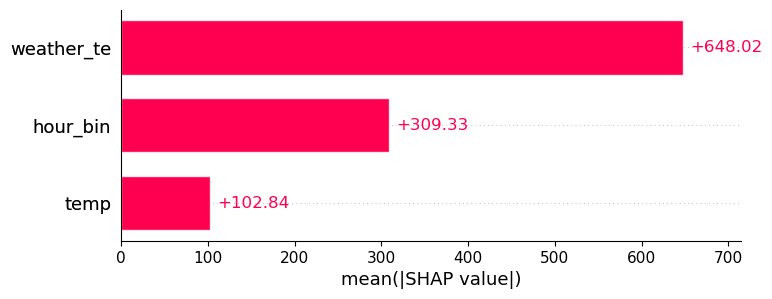

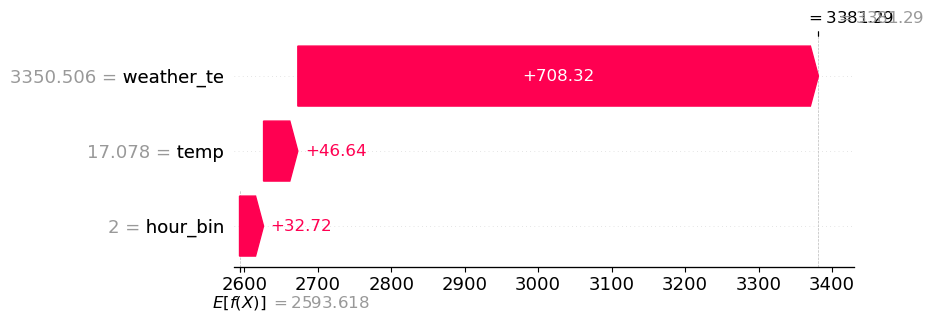

In [3]:
# 🚧 一次性导入依赖
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

# ✅ 1. 构造模拟交通数据
np.random.seed(42)
n = 3000
df = pd.DataFrame({
    "hour": np.random.randint(0, 24, size=n),
    "weather_main": np.random.choice(["Clear", "Clouds", "Rain", "Snow"], size=n),
    "temp": np.random.normal(loc=20, scale=5, size=n)
})
weather_effect = {"Clear": 1000, "Clouds": 800, "Rain": -300, "Snow": -500}
df["traffic_volume"] = (
    3000
    + df["weather_main"].map(weather_effect)
    + 20 * (df["temp"] - 20)
    - 100 * np.abs(df["hour"] - 8)
    + np.random.normal(scale=200, size=n)
).astype(int)

# ✅ 2. 对 hour 特征进行分箱
bin_encoder = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
df["hour_bin"] = bin_encoder.fit_transform(df[["hour"]])

# ✅ 3. 拆分训练集 / 测试集
X = df[["weather_main", "temp", "hour_bin"]]
y = df["traffic_volume"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 4. 构建预处理器（目标编码）+ XGBoost 模型管道
preprocessor = ColumnTransformer([
    ("target_encode", TargetEncoder(cols=["weather_main"]), ["weather_main"]),
    ("passthrough", "passthrough", ["temp", "hour_bin"])
])
pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", XGBRegressor(n_estimators=100, random_state=42))
])
pipeline.fit(X_train, y_train)

# ✅ 5. 模型解释 - SHAP 分析
explainer = shap.Explainer(pipeline.named_steps["reg"])
X_transformed = pipeline.named_steps["pre"].transform(X_test)

# 添加特征名便于解释
X_shap = pd.DataFrame(X_transformed, columns=["weather_te", "temp", "hour_bin"])
shap_values = explainer(X_shap)

# ✅ 6. 可视化
# 全局特征重要性
shap.plots.bar(shap_values)

# 局部 waterfall 图（解释第一个样本）
shap.plots.waterfall(shap_values[0])
